In [1]:
import os
os.chdir("/workspace/")
import sys
sys.path.append("/workspace/reni_neus")


import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plotly.graph_objects as go
from torch.utils.data import Dataset

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.cameras.rays import RayBundle
from nerfstudio.utils.colormaps import apply_depth_colormap
from nerfstudio.field_components.encodings import SHEncoding, NeRFEncoding
import tinycudann as tcnn

from reni_neus.reni_neus_model import RENINeuSFactoModelConfig, RENINeuSFactoModel
from reni_neus.utils.utils import get_directions, get_sineweight, look_at_target, random_points_on_unit_sphere
from reni_neus.illumination_fields.reni_field import RENIField
from reni_neus.data.reni_neus_datamanager import RENINeuSDataManagerConfig, RENINeuSDataManager
from reni_neus.reni_neus_config import RENINeuS as RENINeuSMethodSpecification, DirectionalDistanceField
from reni_neus.reni_neus_config import RENINeuS
from reni_neus.illumination_fields.environment_map import EnvironmentMapConfig

def rotation_matrix(axis: np.ndarray, angle: float) -> np.ndarray:
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    rotation = np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    # convert to pytorch
    rotation = torch.from_numpy(rotation).float()
    return rotation

def get_reni_image(model, outputs, batch, R):
    idx = torch.tensor(batch["image_idx"], device=model.device)
    W = 512
    H = W // 2
    D = get_directions(W).to(model.device)  # [B, H*W, 3]
    envmap, _ = model.get_illumination_field()(idx, None, D, R, "envmap")
    envmap = envmap.reshape(1, H, W, 3).squeeze(0)
    return envmap

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

reni_neus_ckpt_path = '/workspace/outputs/unnamed/reni-neus/2023-06-07_141907/' # model without vis
step = 85000

ckpt = torch.load(reni_neus_ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
reni_neus_model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        reni_neus_model_dict[key[7:]] = ckpt['pipeline'][key]

# vision model checkpoint
vision_ckpt_path = '/workspace/outputs/unnamed/ddf/2023-06-20_085448/' # model without vis
step = 20000

ckpt = torch.load(vision_ckpt_path + '/nerfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
vision_model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        vision_model_dict[key[7:]] = ckpt['pipeline'][key]

# update reni_neus_model_dict with vision_model_dict
for key in vision_model_dict.keys():
    reni_neus_model_dict['visibility_field.' + key] = vision_model_dict[key]

# save reni_neus_model_dict
torch.save(reni_neus_model_dict, '/workspace/outputs/nerfstudio_models' + f'/step-{step:09d}_with_vis.ckpt')

datamanager: RENINeuSDataManager = RENINeuS.config.pipeline.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)

# instantiate model with config with vis
model = RENINeuS.config.pipeline.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_val_data=datamanager.num_val,
    num_test_data=datamanager.num_test,
    test_mode=test_mode,
)

model.to(device)
model.load_state_dict(reni_neus_model_dict)
model.eval()

print('Model loaded')

Setting up training dataset...

Caching all 160 images.

Output()

Setting up evaluation dataset...

Caching all 5 images.

Output()

Model loaded


In [6]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
model.config.fix_test_illumination_directions = True
model.render_rgb = False
model.render_accumulation = True
model.render_depth = True
model.render_normal = False
model.render_albedo = False
model.render_shadow_map = True
model.render_shadow_map_static = True
model.shadow_map_threshold.value = 0.2
model.shadow_map_azimuth.value = 90.0
model.shadow_map_elevation.value = 45.0
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=None)

Output()

In [2]:
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
model.config.use_visibility = True
model.render_shadow_map = False
model.visibility_threshold = 0.1
model.shadow_map_threshold.value = 0.1
model.config.fix_test_illumination_directions = True
model.accumulation_mask_threshold.value = 0.7
model.illumination_sampler.set_icosphere_order(5)
model.render_illumination_animation(ray_bundle=ray_bundle,
                                    batch=None,
                                    num_frames=100, 
                                    fps=20,
                                    visibility_threshold=0.1, 
                                    output_path='/workspace/outputs/renders/')

Output()

: 

: 

Output()

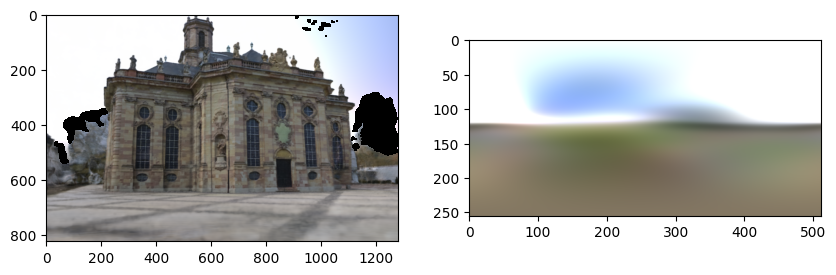

In [5]:
model.visibility_threshold = 1.0
model.config.fix_test_illumination_directions = True
# convert from degrees to radians
R = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.deg2rad(80)) # RENI is Y-up 
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=R)
envmap = get_reni_image(model, outputs, batch, R)
# plot rgb and envmap side by side
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(outputs["rgb"].detach().cpu().numpy())
ax2 = fig.add_subplot(122)
ax2.imshow(envmap.detach().cpu().numpy())
plt.show()

Output()

/home/user/.local/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


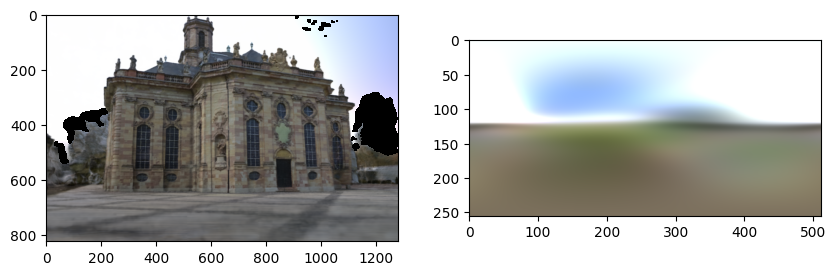

In [2]:
model.visibility_threshold = 0.5
model.config.fix_test_illumination_directions = True
R = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.deg2rad(80))
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=R)
envmap = get_reni_image(model, outputs, batch, R)
# plot rgb and envmap side by side
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(outputs["rgb"].detach().cpu().numpy())
ax2 = fig.add_subplot(122)
ax2.imshow(envmap.detach().cpu().numpy())
plt.show()

Output()

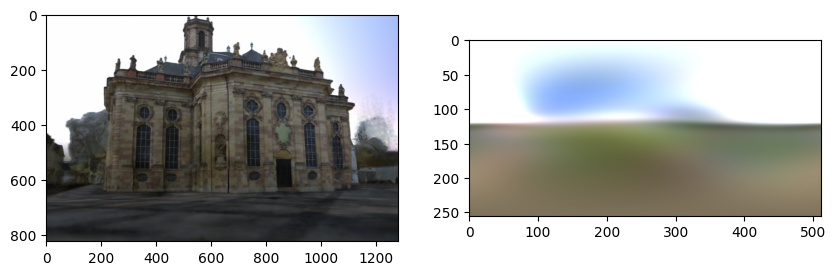

In [6]:
model.visibility_threshold = 0.2
model.config.fix_test_illumination_directions = True
R = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.deg2rad(80))
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=R)
envmap = get_reni_image(model, outputs, batch, R)
# plot rgb and envmap side by side
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(outputs["rgb"].detach().cpu().numpy())
ax2 = fig.add_subplot(122)
ax2.imshow(envmap.detach().cpu().numpy())
plt.show()

Output()

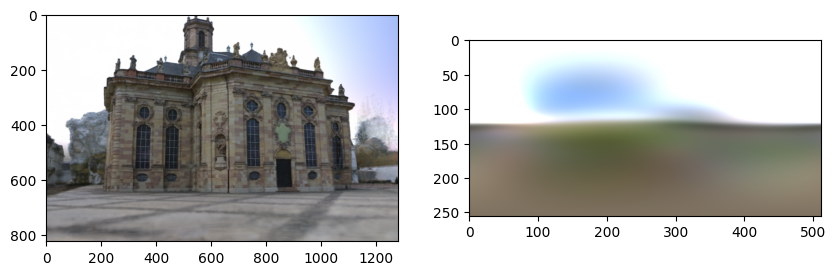

In [2]:
model.config.use_visibility = True
model.render_shadow_map = False
model.visibility_threshold = 0.1
model.shadow_map_threshold.value = 0.01
model.config.fix_test_illumination_directions = True
model.accumulation_mask_threshold.value = 0.7
model.illumination_sampler.set_icosphere_order(5)
R = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.deg2rad(80))
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=R)
envmap = get_reni_image(model, outputs, batch, R)
# plot rgb and envmap side by side
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.imshow(outputs["rgb"].detach().cpu().numpy())
ax2 = fig.add_subplot(122)
ax2.imshow(envmap.detach().cpu().numpy())
plt.show()

In [8]:
outputs.keys()

dict_keys(['rgb', 'albedo', 'accumulation', 'depth', 'p2p_dist', 'normal', 'weights', 'background_colours', 'directions_norm', 'shadow_map', 'prop_depth_0', 'prop_depth_1', 'normal_vis'])

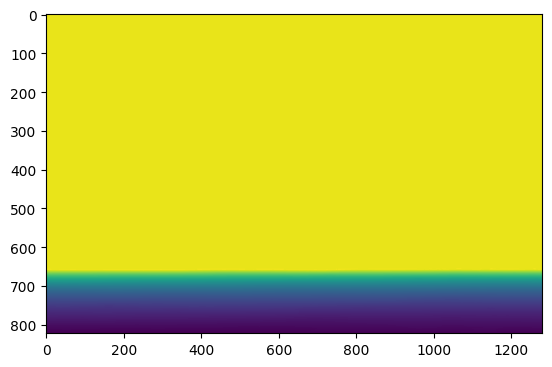

In [4]:
plt.imshow(outputs['depth'].cpu().detach().numpy())

In [2]:
# debugging nan values
model.visibility_threshold = 0.1
model.config.fix_test_illumination_directions = True
R = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.deg2rad(80))
ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
ray_bundle = ray_bundle[400:403, 1200:1203]
# if item in batch is tensor, then slice it
for key in batch.keys():
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key][400:401, 1200:1201]
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True, rotation=R)

Output()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torch
import os
import imageio
from tqdm import tqdm
import cv2

# Setup
model.visibility_threshold = 0.1
model.config.fix_test_illumination_directions = True
N = 100  # Number of frames
saved_data = []

path = '/workspace/outputs/renders/render_frames'
# Creating a directory to save the intermediate .pt files
if not os.path.exists(path):
    os.makedirs(path)

# Check if the render_sequence.pt file already exists
if os.path.exists('/workspace/outputs/renders/render_sequence.pt'):
    saved_data = torch.load('/workspace/outputs/renders/render_sequence.pt')
else:
    for i in tqdm(range(N)):  # Wrap the loop with tqdm for progress bar
        angle = i * (360 / N)  # angle in degrees
        R = rotation_matrix(axis=np.array([0, 1, 0]), angle=np.deg2rad(angle))  # RENI is Y-up

        pt_file_path = f'{path}/frame_{i}.pt'

        if os.path.exists(pt_file_path):
            # Load already computed frame
            frame_data = torch.load(pt_file_path)
            outputs = frame_data["outputs"]
            envmap = frame_data["envmap"]
        else:
            # Compute the frame
            ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
            outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=False, rotation=R)
            envmap = get_reni_image(model, outputs, batch, R)

            # Saving the outputs and envmap to .pt file for each frame
            torch.save({"outputs": outputs, "envmap": envmap}, pt_file_path)

        # Storing the data in memory for final animation
        saved_data.append((outputs["rgb"].detach().cpu().numpy(), envmap.detach().cpu().numpy()))


    # Save entire sequence to a .pt file
    torch.save(saved_data, '/workspace/outputs/renders/render_sequence.pt')

# Create the animation
rgb_images = []
envmap_images = []

for rgb, envmap in saved_data:
    # ensure no nan or inf values
    rgb = np.nan_to_num(rgb)
    envmap = np.nan_to_num(envmap)
    rgb_images.append(rgb)
    envmap_images.append(envmap)

# Assuming rgb_images are in range [0, 1] and have shape (height, width, channels)
rgb_images = np.array(rgb_images)  # convert list to numpy array
rgb_images = (rgb_images * 255).astype(np.uint8)  # scale to [0, 255] and convert to uint8

height, width, channels = rgb_images[0].shape
fps = 20

# Define the codec using VideoWriter_fourcc and creat7e a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('rgb_animation.mp4', fourcc, fps, (width, height))

for frame in rgb_images:
    # OpenCV uses BGR format, so we need to convert RGB to BGR
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video.write(frame_bgr)

video.release()



100%|██████████| 100/100 [2:33:23<00:00, 92.03s/it] 


In [14]:
import cv2

# Assuming rgb_images are in range [0, 1] and have shape (height, width, channels)
rgb_images = np.array(rgb_images)  # convert list to numpy array
rgb_images = (rgb_images * 255).astype(np.uint8)  # scale to [0, 255] and convert to uint8

height, width, channels = rgb_images[0].shape
fps = 20

# Define the codec using VideoWriter_fourcc and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('rgb_animation.mp4', fourcc, fps, (width, height))

for frame in rgb_images:
    # OpenCV uses BGR format, so we need to convert RGB to BGR
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video.write(frame_bgr)

video.release()


Output()

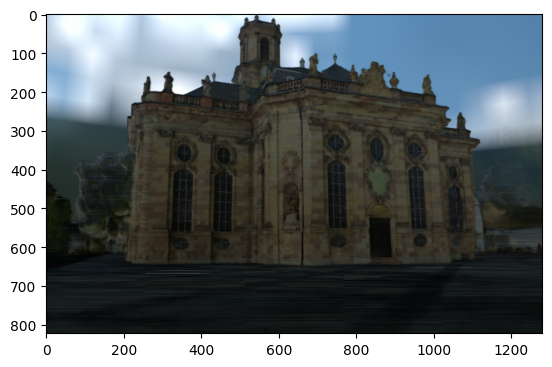

In [4]:
model.visibility_threshold = 0.2

envmap_config = EnvironmentMapConfig(
    path=Path('/workspace/data/RENI_HDR/Test/00001.exr'))

model.illumination_field_test = envmap_config.setup(num_latent_codes=model.num_test_data)
model.illumination_field_train = envmap_config.setup(num_latent_codes=model.num_train_data)
model.illumination_field_val = envmap_config.setup(num_latent_codes=model.num_val_data)

ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
outputs = model.get_outputs_for_camera_ray_bundle(ray_bundle, show_progress=True)
# envmap = get_reni_image(model, outputs, batch, None)
# plot rgb and envmap side by side
plt.imshow(outputs["rgb"].detach().cpu().numpy())

In [1]:
from reni_neus.illumination_fields.environment_map import EnvironmentMapConfig
from pathlib import Path
import matplotlib.pyplot as plt
from reni_neus.utils.utils import get_directions
import torch

envmap_config = EnvironmentMapConfig(
    path=Path('/workspace/data/RENI_HDR/Test/00001.exr'))
envmap_field = envmap_config.setup(num_latent_codes=1)

H, W = 256, 512

directions = get_directions(W, convention='Nerfstudio').squeeze(0)

camera_indices = torch.zeros(10, 5).type(torch.int64)
positions = None

illumination_colours, illumination_directions = envmap_field(camera_indices=camera_indices,
                                                              positions=positions,
                                                              directions=directions,
                                                              rotation=None,
                                                              illumination_type='illumination')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


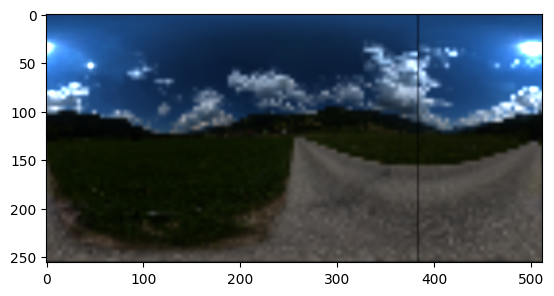

In [2]:
# plot illumination colours [0] [num_directions, 3]
plt.imshow(illumination_colours[0].reshape(H, W, 3).detach().cpu().numpy())

In [70]:
import torch
from matplotlib import pyplot as plt

path = '/workspace/outputs/ddf/cache/lk2_data.pt'
data = torch.load(path)


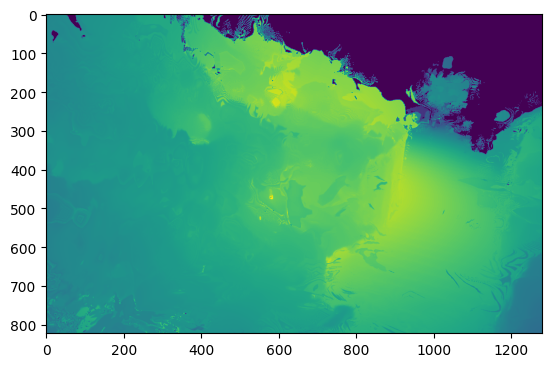

In [91]:
idx = 3
use_xyz = True
origins = data[idx]['ray_bundle'].origins
directions = data[idx]['ray_bundle'].directions
depths = data[idx]['termination_dist']
mask = data[idx]['mask']

# ensure all on cpu
origins = origins.cpu()
directions = directions.cpu()
depths = depths.cpu()
mask = mask.cpu()

positions = origins + directions * depths
positions = origins + directions * depths

if use_xyz:
    # use XYZ
    distance_from_center = torch.norm(positions, dim=-1)
else:
    # use only the XY plane, ignoring the Z coordinate
    distance_from_center = torch.norm(positions[..., :2], dim=-1)

# normalize to [0, 1]
distance_from_center = distance_from_center / 1.0
# invert so that points closer to the center have higher weight
exponent = 1.5  # adjust this to tune the rate of decrease
distance_weight = 1.0 - distance_from_center**exponent

plt.imshow((distance_weight * mask.squeeze()).detach().cpu().numpy())

In [55]:
mask.shape

torch.Size([823, 1280, 1])

In [2]:
from reni_neus.illumination_fields.environment_map import EnvironmentMapConfig
from pathlib import Path
import matplotlib.pyplot as plt
from reni_neus.utils.utils import get_directions
import torch
from tqdm import tqdm

envmap_config = EnvironmentMapConfig(
    path=Path('/workspace/data/RENI_HDR/Test/00001.exr'))
envmap_field = envmap_config.setup(num_latent_codes=6)

# Get LDR colour of the background for rays from the camera that don't hit the scene
full_ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
num_rays = len(full_ray_bundle)
num_rays_per_chunk = 256
H, W = full_ray_bundle.shape

background_colours_list = []
for i in tqdm(range(0, num_rays, num_rays_per_chunk)):
    start_idx = i
    end_idx = i + num_rays_per_chunk
    ray_bundle = full_ray_bundle.get_row_major_sliced_ray_bundle(start_idx, end_idx)
    directions = ray_bundle.directions.reshape(-1, 3)
    camera_indices = ray_bundle.camera_indices.reshape(-1, 1)
    background_colours, _ = envmap_field(
        camera_indices=camera_indices,
        positions=None,
        directions=directions,
        rotation=None,
        illumination_type="background",
    )
    background_colours_list.append(background_colours)

background_colours = torch.cat(background_colours_list, dim=0)


100%|██████████| 4115/4115 [00:02<00:00, 1431.36it/s]


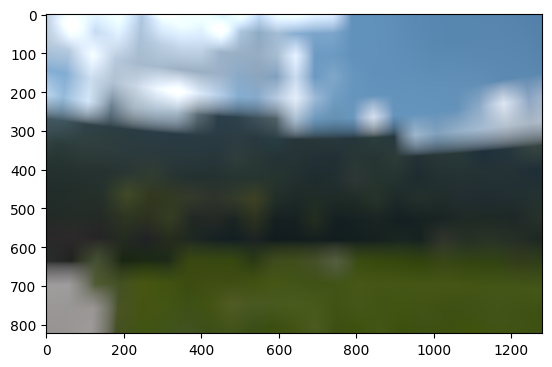

In [3]:
background_colours = background_colours.reshape(H, W, 3).detach().cpu().numpy()
plt.imshow(background_colours)

In [10]:
from reni_neus.illumination_fields.environment_map import EnvironmentMapConfig
from pathlib import Path
import matplotlib.pyplot as plt
from reni_neus.utils.utils import get_directions
import torch
from tqdm import tqdm

envmap_config = EnvironmentMapConfig(
    path=Path('/workspace/data/RENI_HDR/Test/00001.exr'))
envmap_field = envmap_config.setup(num_latent_codes=6)

# Get LDR colour of the background for rays from the camera that don't hit the scene
full_ray_bundle, batch = datamanager.fixed_indices_eval_dataloader.get_data_from_image_idx(3)
num_rays = len(full_ray_bundle)
num_rays_per_chunk = 256
H, W = full_ray_bundle.shape
directions = full_ray_bundle.directions.reshape(-1, 3)
camera_indices = full_ray_bundle.camera_indices.reshape(-1, 1)
background_colours, _ = envmap_field(
    camera_indices=camera_indices,
    positions=None,
    directions=directions,
    rotation=None,
    illumination_type="background",
)

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 13316830003200 bytes. Error code 12 (Cannot allocate memory)

In [14]:
unique_indices, inverse_indices = torch.unique(camera_indices, return_inverse=True)
unique_indices.to(envmap_field.environment_maps.device)

tensor([3])

In [12]:
envmap_field.environment_maps[unique_indices]

RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [16]:
unique_indices

tensor([3], device='cuda:0')

In [ ]:
# create exr file 